## Data Import


In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC, Accuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [2]:
df_train = pd.read_csv("dataset/output/train.csv")
df_test = pd.read_csv("dataset/output/test.csv")

In [5]:
df_train.head()

,sex,pregnant,lithium,TSH,T3_measured,T4U,FTI,TBG_measured,target
0,0,0,0,1.70,1,0.98,99.0,0,1
1,0,1,0,0.05,1,1.75,165.0,0,1
2,1,0,0,0.25,1,0.75,166.0,0,1
3,1,0,0,1.00,1,0.95,101.0,0,1
4,0,0,0,0.10,0,0.82,145.0,0,0


## Data Preparation


In [3]:
# split into X_train, y_train, X_test, y_test
X_train = df_train.drop(columns=["target"])
y_train = df_train["target"]
X_test = df_test.drop(columns=["target"])
y_test = df_test["target"]

In [4]:
# normalize X_train, X_test, y_train, y_test
X_train = normalize(X_train)
X_test = normalize(X_test)
y_train = normalize(y_train.values.reshape(-1, 1))
y_test = normalize(y_test.values.reshape(-1, 1))

## Helper Functions


In [5]:
# This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric="accuracy"):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

## Model Building


### Base Model


In [9]:
# create a base LSTM model
def create_model():
    model = Sequential()
    model.add(
        LSTM(
            units=128,
            return_sequences=True,
            input_shape=(X_train.shape[1], 1),
        )
    )
    model.add(Dropout(0.2))
    model.add(LSTM(units=128))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", Precision(), Recall()],
    )
    return model

In [13]:
# initialize model and fit to data
model = create_model()
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
)

Epoch 1/100
351/351 [==============================] - 20s 32ms/step - loss: 0.6936 - accuracy: 0.4933 - precision_2: 0.4934 - recall_2: 0.4993 - val_loss: 0.6942 - val_accuracy: 0.3550 - val_precision_2: 0.3550 - val_recall_2: 1.0000
Epoch 2/100
351/351 [==============================] - 9s 25ms/step - loss: 0.6934 - accuracy: 0.4981 - precision_2: 0.4979 - recall_2: 0.4466 - val_loss: 0.6977 - val_accuracy: 0.3550 - val_precision_2: 0.3550 - val_recall_2: 1.0000
Epoch 3/100
351/351 [==============================] - 8s 22ms/step - loss: 0.6935 - accuracy: 0.4966 - precision_2: 0.4970 - recall_2: 0.5670 - val_loss: 0.6895 - val_accuracy: 0.6450 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/100
351/351 [==============================] - 8s 21ms/step - loss: 0.6933 - accuracy: 0.5020 - precision_2: 0.5020 - recall_2: 0.5189 - val_loss: 0.6957 - val_accuracy: 0.3550 - val_precision_2: 0.3550 - val_recall_2: 1.0000
Epoch 5/100
351/351 [==============================] - 

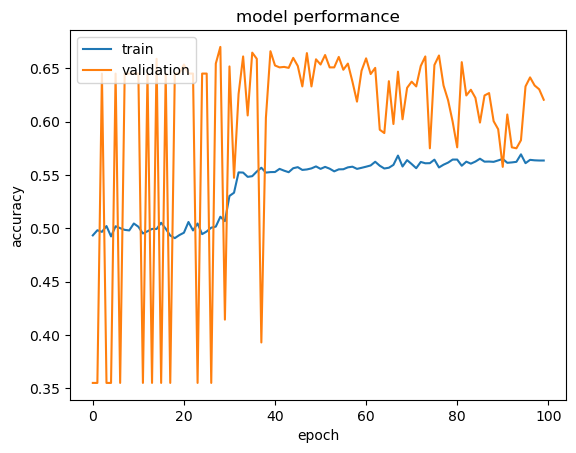

In [14]:
plot_hist(history)

In [15]:
# print confusion matrix and accuracy
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 2s 8ms/step
Accuracy:  0.6204281891168599

Confusion Matrix: 
 [[1084  362]
 [ 489  307]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.69      0.75      0.72      1446
         1.0       0.46      0.39      0.42       796

    accuracy                           0.62      2242
   macro avg       0.57      0.57      0.57      2242
weighted avg       0.61      0.62      0.61      2242



In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8, 128)            66560     
                                                                 
 dropout_4 (Dropout)         (None, 8, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


### Tuned Model


In [6]:
def model_builder(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int("units", min_value=32, max_value=256, step=32),
            return_sequences=True,
            input_shape=(X_train.shape[1], 1),
        )
    )
    model.add(Dropout(hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int("units", min_value=32, max_value=256, step=32)))
    model.add(Dropout(hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(
        Dense(1, activation=hp.Choice(
            "dense_activation", ["tanh", "relu", "sigmoid"]))
    )
    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "rmsprop", "sgd"]),
        loss=hp.Choice("loss", ["binary_crossentropy", "mean_squared_error"]),
        metrics=["accuracy", Precision(), Recall()],
    )
    return model

In [7]:
# RandomSearch to find the best hyperparameters
tuner = kt.RandomSearch(
    model_builder,
    objective="val_accuracy",
    max_trials=30,
    executions_per_trial=3,
    directory="lstm",
    project_name="lstm",
)

tuner.search(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
)

Trial 30 Complete [00h 01m 15s]
val_accuracy: 0.4516800443331401

Best val_accuracy So Far: 0.6573000351587931
Total elapsed time: 00h 20m 58s
INFO:tensorflow:Oracle triggered exit


In [8]:
# get params of best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units': 160,
 'dropout': 0.30000000000000004,
 'dense_activation': 'relu',
 'optimizer': 'adam',
 'loss': 'binary_crossentropy'}

In [9]:
# get best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 160)            103680    
                                                                 
 dropout (Dropout)           (None, 8, 160)            0         
                                                                 
 lstm_1 (LSTM)               (None, 160)               205440    
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 309,281
Trainable params: 309,281
Non-trainable params: 0
_________________________________________________________________


In [10]:
# build and fit best model
best_model.build(X_train.shape)
history = best_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    # callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
)

Epoch 1/100


351/351 [==============================] - 20s 35ms/step - loss: 0.6964 - accuracy: 0.5183 - precision: 0.5201 - recall: 0.4720 - val_loss: 0.7335 - val_accuracy: 0.3550 - val_precision: 0.3550 - val_recall: 1.0000
Epoch 2/100
351/351 [==============================] - 11s 31ms/step - loss: 0.6990 - accuracy: 0.5117 - precision: 0.5132 - recall: 0.4539 - val_loss: 0.6904 - val_accuracy: 0.6106 - val_precision: 0.4449 - val_recall: 0.3907
Epoch 3/100
351/351 [==============================] - 11s 31ms/step - loss: 0.6963 - accuracy: 0.5175 - precision: 0.5195 - recall: 0.4653 - val_loss: 0.6871 - val_accuracy: 0.6521 - val_precision: 0.5198 - val_recall: 0.2638
Epoch 4/100
351/351 [==============================] - 11s 32ms/step - loss: 0.6963 - accuracy: 0.5066 - precision: 0.5073 - recall: 0.4608 - val_loss: 0.6812 - val_accuracy: 0.6682 - val_precision: 0.6048 - val_recall: 0.1884
Epoch 5/100
351/351 [==============================] - 11s 31ms/step - loss: 0.6945 - accuracy: 0.5166 -

In [11]:
# print confusion matrix and accuracy for best model
y_pred = best_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 2s 11ms/step
Accuracy:  0.639607493309545

Confusion Matrix: 
 [[1188  258]
 [ 550  246]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.68      0.82      0.75      1446
         1.0       0.49      0.31      0.38       796

    accuracy                           0.64      2242
   macro avg       0.59      0.57      0.56      2242
weighted avg       0.61      0.64      0.62      2242



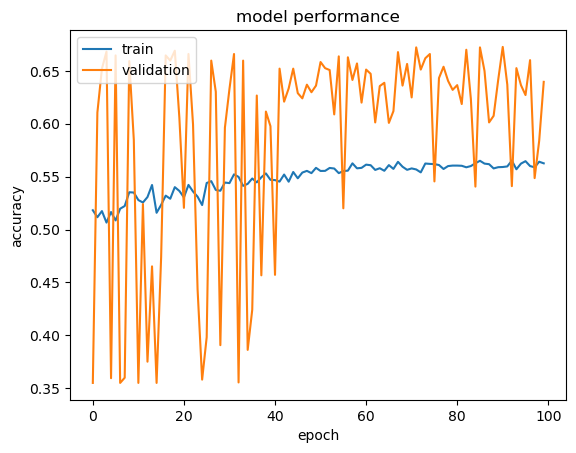

In [12]:
plot_hist(history)